In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-2vzm0r8r
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-2vzm0r8r
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=a0d99021aec8ef5cba731b6faf417dc49cfa6f48d4d51d6df6e1d3704cc6e77e
  Stored in directory: /tmp/pip-ephem-wheel-cache-lz7xz3zl/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-03-04 23:37:44--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

## Set-up

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [ ]:
image = cv2.imread('images/dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

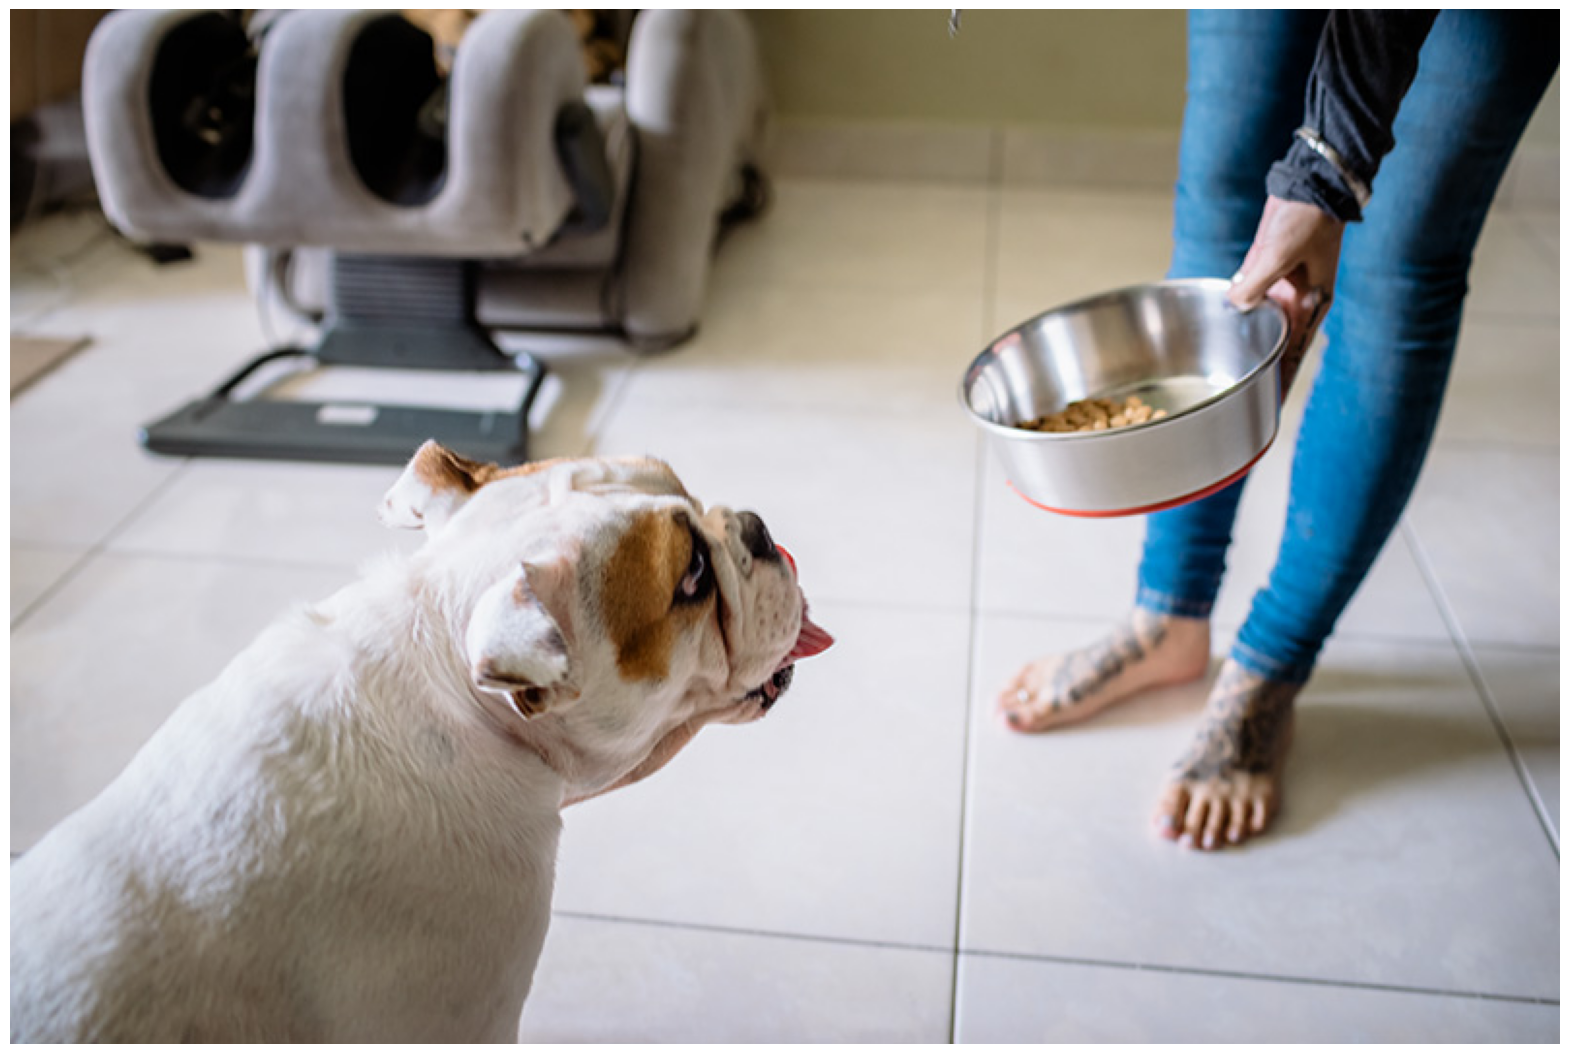

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


To generate masks, just run `generate` on an image.

In [ ]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
print(len(masks))
print(masks[0].keys())

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

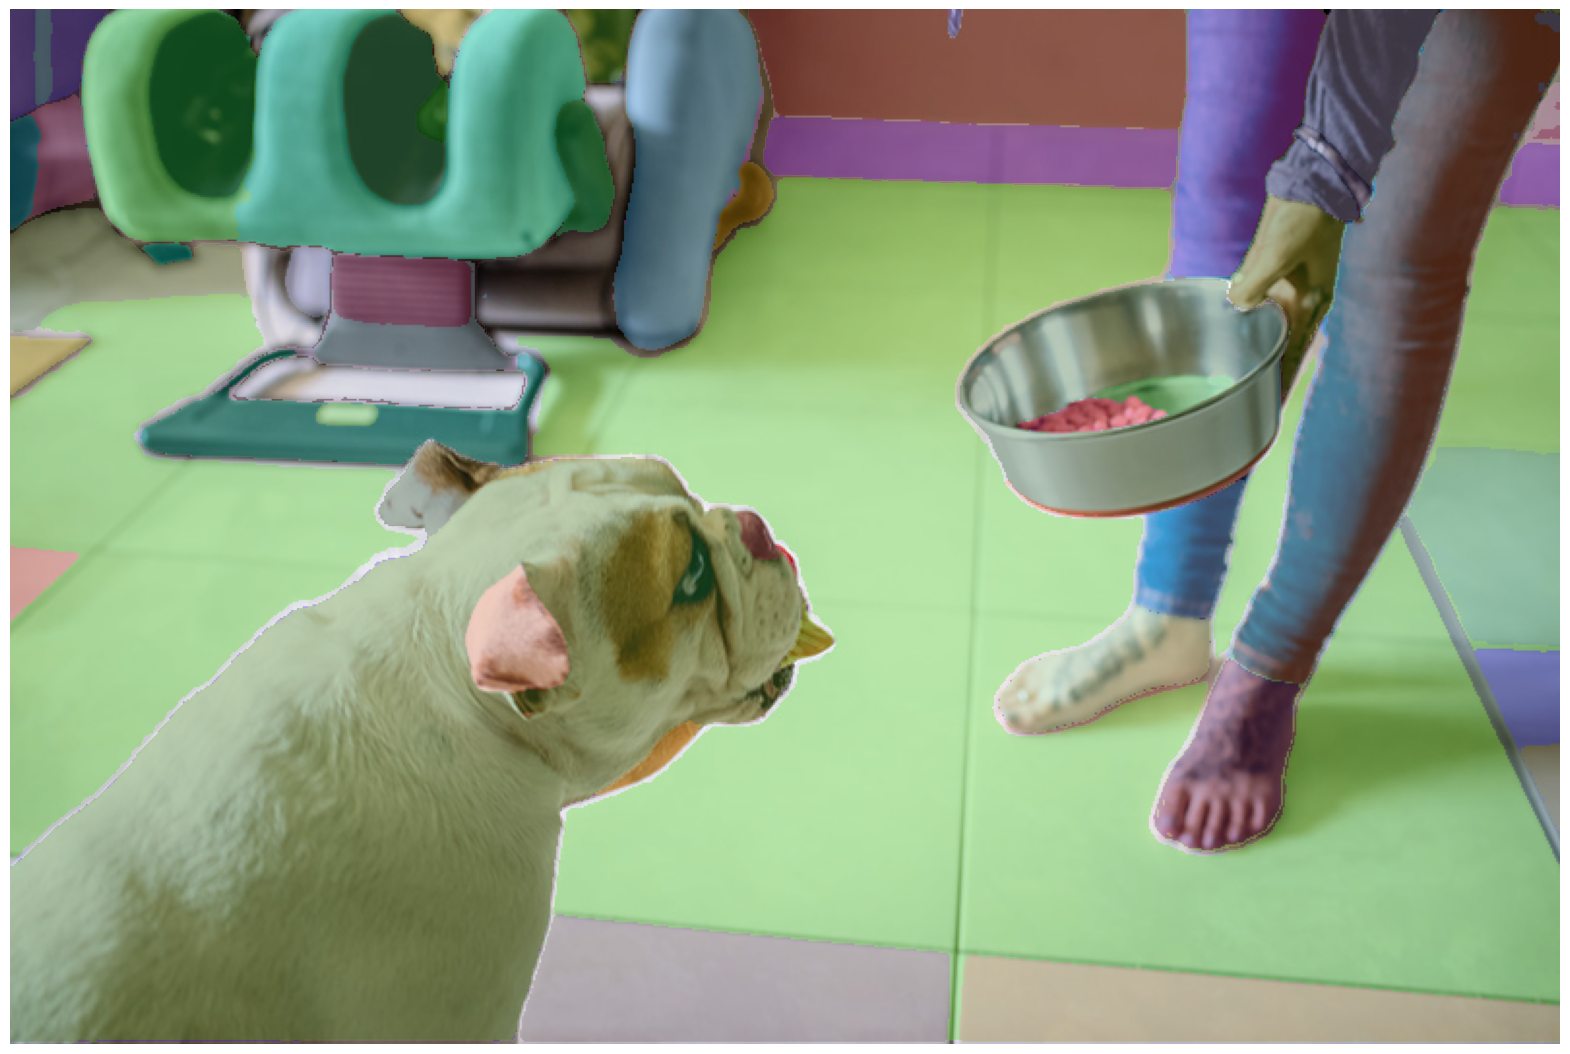

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)

90

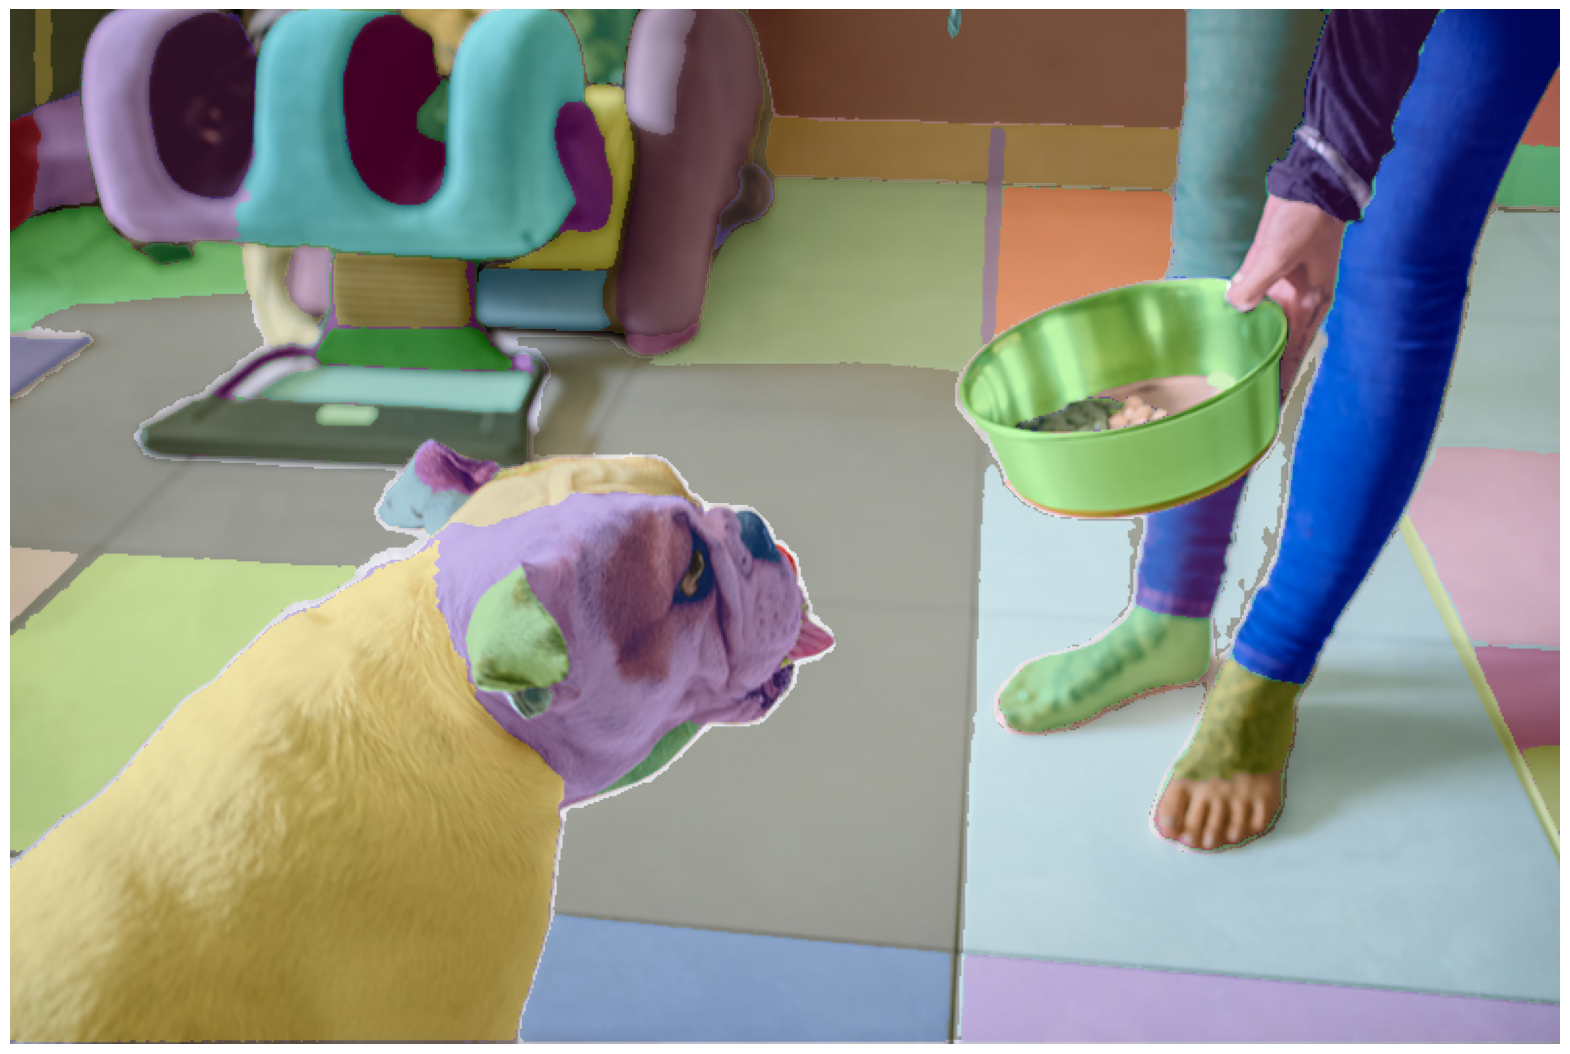

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

Everything that follows is my code. Everything above is not (unless that changes after I write this and I forget)

We want to run through a set of different configurations and for each one obtain a mask for each of a set of test plant images. These config-result sets will be examined by our domain experts to judge if any configuration can obtain results of an adequate quality.

Configurable parameters:
Arguments:

          model (Sam): The SAM model to use for mask prediction.

          points_per_side (int or None): The number of points to be sampled
            along one side of the image. The total number of points is
            points_per_side**2. If None, 'point_grids' must provide explicit
            point sampling.

          points_per_batch (int): Sets the number of points run simultaneously
            by the model. Higher numbers may be faster but use more GPU memory.

          pred_iou_thresh (float): A filtering threshold in [0,1], using the
            model's predicted mask quality.

          stability_score_thresh (float): A filtering threshold in [0,1], using
            the stability of the mask under changes to the cutoff used to binarize
            the model's mask predictions.

          stability_score_offset (float): The amount to shift the cutoff when
            calculated the stability score.

          box_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks.

          crop_n_layers (int): If >0, mask prediction will be run again on
            crops of the image. Sets the number of layers to run, where each
            layer has 2**i_layer number of image crops.

          crop_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks between different crops.

          crop_overlap_ratio (float): Sets the degree to which crops overlap.
            In the first crop layer, crops will overlap by this fraction of
            the image length. Later layers with more crops scale down this overlap.

          crop_n_points_downscale_factor (int): The number of points-per-side
            sampled in layer n is scaled down by crop_n_points_downscale_factor**n.

          point_grids (list(np.ndarray) or None): A list over explicit grids
            of points used for sampling, normalized to [0,1]. The nth grid in the
            list is used in the nth crop layer. Exclusive with points_per_side.

          min_mask_region_area (int): If >0, postprocessing will be applied
            to remove disconnected regions and holes in masks with area smaller
            than min_mask_region_area. Requires opencv.

          output_mode (str): The form masks are returned in. Can be 'binary_mask',
            'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools.
            For large resolutions, 'binary_mask' may consume large amounts of
            memory.

Out of these the ones worth playing around with seem to be:
1. points_per_side: larger number = more likely to have more elements in the image? In which case we might increase this if we're finding the whole plant to be 1 object instead of the 3-4 it should be, or we'd decrease it if we find a lot of unwanted objects around in the background.
2. pred_iou_thresh: much like the above, larger number seems to mean we'll find more things because we include things we're less confident about. This seems like a more promising thing to vary than points_per_side toward this end
3. stability_score_thresh: this seems like the reverse of the above, where a bigger number means we allow less stable predictions. This seems like a useful tool in particular for not finding random unwanted objects in the black background
4. box_nms_thresh: big number = we allow more overlap in shapes. This seems good to have high because we expect to worry about overlap in boxes on the plant but not in the non-objects in the background that SAM finds
5. crop_n_layers: small number = less finding random background things, but maybe less precision on our big things too?
6. crop_nms_thresh and crop_overlap_ratio?: small number = fewer crops which seems useful because we expect few good crops in the image since a lot is background
7. crop_n_points_downscale_factor: big number = more precise, we like big numbers here because the only cost is that we're slower and speed doesn't matter at this phase
8. min_mask_region_area: big number = fewer small background fake objects

Here are my thoughts pre-testing for what matters and how much to play around with it and why:
1. points_per_side: {32, 64}: larger value might help us detect smaller things like the seed
2. points_per_batch: {64}: this is for processing speed which we don't care about right now
3. pred_iou_thresh: {0.8, 0.9}: higher values will help remove unclear noise but will be a larger risk of missing important things
4. stability_score_thresh: {0.95}: noise is unlikely to be removed successfully via stability so no change on this
5. stability_score_offset: {1}: the background artifacts don't seem unstable so this doesn't appear useful
6. box_nms_thresh: {0.7, 0.9}: the seed, leaf, and stem overlap a lot and we might need a big value here for high accuracy
7. crop_n_layers: {0, 1, 2}: this seems impactful for more precision via higher values
8. crop_nms_thresh: {0.7, 0.9}: the seed, leaf, and stem overlap a lot and we might need a big value here for high accuracy
9. crop_overlap_ratio: {0.3, 0.5}: the seed, leaf, and stem overlap a lot and we might need a big value here for high accuracy
10. crop_n_points_downscale_factor: {1}: lower number = higher precision which is important for us
11. point_grids: {None}: looks like we can ignore this unless we have trouble finding small objects (like the seed)
12. min_mask_region_area: {0}: looks like background artifacts are larger than some of the important plant parts so it doesn't look like this will be helpful

The varying things should thus be:
1. points_per_side: find smaller objects
2. pred_iou_thresh: required confidence
3. box_nms_thresh, crop_nms_thresh, crop_overlap_ratio: overlapping part accuracy
4. crop_n_layers: higher fine precision

We'll vary these 4 things for 2x2x2x3 = 24 total sets. This seems like a bit much but hopefully still parsable by us.

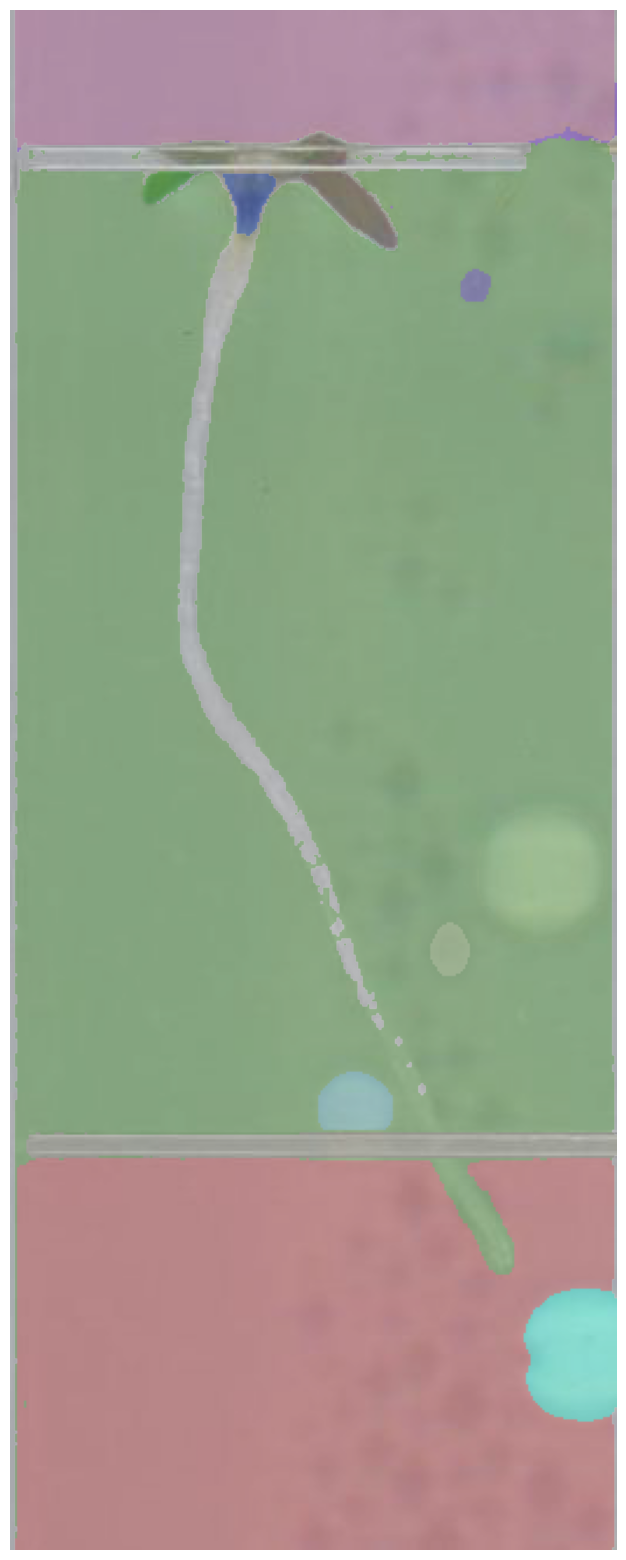

In [ ]:
# test running SAM on a plant without fine tuning parameters

# to run: add plant.jpg to the images directory
plant_image = cv2.imread('images/plant.jpg')
plant_image = cv2.cvtColor(plant_image, cv2.COLOR_BGR2RGB)
plant_masks = mask_generator.generate(plant_image)

plt.figure(figsize=(20,20))
plt.imshow(plant_image)
show_anns(plant_masks)
plt.axis('off')
plt.show()

In [ ]:
def get_mask_generators():
  mask_generators = {}

  # higher = detect smaller objects
  points_per_side = {
      "detectBig": 32,
      "detectSmall": 64,
    } # default = 32

  # higher = require more confidence
  pred_iou_thresh = {
      "lowConfidence": 0.8,
      "highConfidence": 0.9,
    } # default = 0.88

  # higher = finer shape detail
  crop_n_layers = {
      "normalDetail": 0,
      "fineDetail": 1,
      "veryFineDetail": 2,
    } # default = 0

  # these 3 are grouped together with either the lower of higher value
  overlapNames = ["lowOverlap", "highOverlap"]
  # higher = allow more overlap in objects
  box_nms_thresh = [0.7, 0.9] # default = 0.7
  crop_nms_thresh = [0.7, 0.9] # default = 0.7
  crop_overlap_ratio = [0.3, 0.5] # default = 512/1500

  for sizeName, pps in points_per_side.items():
    for confidenceName, pred_iou in pred_iou_thresh.items():
      for detailName, crop_n in crop_n_layers.items():
        for i in range(len(overlapNames)):
          overlapName = overlapNames[i]
          box_nms = box_nms_thresh[i]
          crop_nms = crop_nms_thresh[i]
          crop_overlap = crop_overlap_ratio[i]

          group_name = f"{sizeName}-{confidenceName}-{detailName}-{overlapName}"

          mask_generators[group_name] = SamAutomaticMaskGenerator(
                model=sam,
                points_per_side = pps,
                points_per_batch = 64, # default
                pred_iou_thresh = pred_iou,
                stability_score_thresh = 0.95, # default
                stability_score_offset = 1.0, # default
                box_nms_thresh = box_nms,
                crop_n_layers = crop_n,
                crop_nms_thresh = crop_nms,
                crop_overlap_ratio = crop_overlap,
                crop_n_points_downscale_factor = 1, # default
                point_grids = None, # default
                min_mask_region_area = 0, # default
                output_mode = "binary_mask", # default, we'll want to get polygons in the future via this
          )

  return mask_generators

# we should get 2*2*3*2 = 24 total combinations
mask_generators = get_mask_generators()
assert(len(mask_generators) == 24)

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

def save_masked_images(mask_generators, plant_image, output_base="output_masks"):
    """Runs each mask generator on the plant image and saves the results in separate directories."""

    # Ensure the base output directory exists
    os.makedirs(output_base, exist_ok=True)

    for name, mask_generator in mask_generators.items():
        # Generate masks
        plant_masks = mask_generator.generate(plant_image)

        # Create a directory for this generator
        output_dir = os.path.join(output_base, name)
        os.makedirs(output_dir, exist_ok=True)

        # Plot and annotate the image
        plt.figure(figsize=(20,20))
        plt.imshow(plant_image)
        show_anns(plant_masks)  # Assuming this function correctly overlays masks
        plt.axis('off')

        # Save the image
        filename = f"{name}.png"
        output_path = os.path.join(output_dir, filename)
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()  # Close plot to free memory

        print(f"Saved masked image for '{name}' at: {output_path}")

# Example usage
plant_image = cv2.imread('images/plant.jpg')
plant_image = cv2.cvtColor(plant_image, cv2.COLOR_BGR2RGB)

save_masked_images(mask_generators, plant_image)

Saved masked image for 'detectBig-lowConfidence-normalDetail-lowOverlap' at: output_masks/detectBig-lowConfidence-normalDetail-lowOverlap/detectBig-lowConfidence-normalDetail-lowOverlap.png
Saved masked image for 'detectBig-lowConfidence-normalDetail-highOverlap' at: output_masks/detectBig-lowConfidence-normalDetail-highOverlap/detectBig-lowConfidence-normalDetail-highOverlap.png
Saved masked image for 'detectBig-lowConfidence-fineDetail-lowOverlap' at: output_masks/detectBig-lowConfidence-fineDetail-lowOverlap/detectBig-lowConfidence-fineDetail-lowOverlap.png
Saved masked image for 'detectBig-lowConfidence-fineDetail-highOverlap' at: output_masks/detectBig-lowConfidence-fineDetail-highOverlap/detectBig-lowConfidence-fineDetail-highOverlap.png
Saved masked image for 'detectBig-lowConfidence-veryFineDetail-lowOverlap' at: output_masks/detectBig-lowConfidence-veryFineDetail-lowOverlap/detectBig-lowConfidence-veryFineDetail-lowOverlap.png
Saved masked image for 'detectBig-lowConfidence-ve

From the results above, the strongest results are:
* detectBig-lowConfidence-normalDetail-lowOverlap.png
* detectSmall-highConfidence-normalDetail-highOverlap.png
* detectSmall-highConfidence-normalDetail-lowOverlap.png
* detectSmall-lowConfidence-normalDetail-highOverlap.png
* detectSmall-lowConfidence-normalDetail-lowOverlap.png
* detectBig-lowConfidence-normalDetail-highOverlap.png
* detectBig-highConfidence-normalDetail-lowOverlap.png
* detectBig-highConfidence-normalDetail-highOverlap.png

We can notice that all of the good ones were normal detail, and all of the bad ones were the other detail levels. Nothing else mattered enough to be a noticable difference.

There are still differences beyond that, and I will run image batches on the remaining 8 configurations after normal detail only, however they appear to not be good enough still. It seems we will likely need adapter training.

In [ ]:
def get_mask_generators_v2():
  mask_generators = {}

  # higher = detect smaller objects
  points_per_side = {
      "detectBig": 32,
      "detectSmall": 64,
    } # default = 32

  # higher = require more confidence
  pred_iou_thresh = {
      "lowConfidence": 0.8,
      "highConfidence": 0.9,
    } # default = 0.88

  # these 3 are grouped together with either the lower of higher value
  overlapNames = ["lowOverlap", "highOverlap"]
  # higher = allow more overlap in objects
  box_nms_thresh = [0.7, 0.9] # default = 0.7
  crop_nms_thresh = [0.7, 0.9] # default = 0.7
  crop_overlap_ratio = [0.3, 0.5] # default = 512/1500

  for sizeName, pps in points_per_side.items():
    for confidenceName, pred_iou in pred_iou_thresh.items():
      for i in range(len(overlapNames)):
        overlapName = overlapNames[i]
        box_nms = box_nms_thresh[i]
        crop_nms = crop_nms_thresh[i]
        crop_overlap = crop_overlap_ratio[i]

        group_name = f"{sizeName}-{confidenceName}-{overlapName}"

        mask_generators[group_name] = SamAutomaticMaskGenerator(
              model=sam,
              points_per_side = pps,
              points_per_batch = 64, # default
              pred_iou_thresh = pred_iou,
              stability_score_thresh = 0.95, # default
              stability_score_offset = 1.0, # default
              box_nms_thresh = box_nms,
              crop_n_layers = 0, # default
              crop_nms_thresh = crop_nms,
              crop_overlap_ratio = crop_overlap,
              crop_n_points_downscale_factor = 1, # default
              point_grids = None, # default
              min_mask_region_area = 0, # default
              output_mode = "binary_mask", # default, we'll want to get polygons in the future via this
        )

  return mask_generators

# we should get 2*2*2 = 8 total combinations
mask_generators = get_mask_generators_v2()
assert(len(mask_generators) == 8)

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

def save_masked_images_v2(mask_generators, plant_images, output_base="batched_masks"):
    """Runs each mask generator on the plant image and saves the results in separate directories."""

    # Ensure the base output directory exists
    os.makedirs(output_base, exist_ok=True)

    config_count = 0
    plant_count = 0
    for name, mask_generator in mask_generators.items():
        config_count += 1

        for plant_image in plant_images:
          plant_count += 1

          # Generate masks
          plant_masks = mask_generator.generate(plant_image)

          # Create a directory for this generator
          output_dir = os.path.join(output_base, name)
          os.makedirs(output_dir, exist_ok=True)

          # Plot and annotate the image
          plt.figure(figsize=(20,20))
          plt.imshow(plant_image)
          show_anns(plant_masks)  # Assuming this function correctly overlays masks
          plt.axis('off')

          # Save the image
          filename = f"plant #{plant_count}.png"
          output_path = os.path.join(output_dir, filename)
          plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
          plt.close()  # Close plot to free memory

          print(f"{config_count}:{plant_count} Saved masked image for '{name}' at: {output_path}")

        plant_count = 0

# Example usage
plant_images = []
for i in range(20):
  plant_image = cv2.imread(f'images/plant{i}.jpg')
  plant_image = cv2.cvtColor(plant_image, cv2.COLOR_BGR2RGB)
  plant_images.append(plant_image)

save_masked_images_v2(mask_generators, plant_images)

1:1 Saved masked image for 'detectBig-lowConfidence-lowOverlap' at: batched_masks/detectBig-lowConfidence-lowOverlap/plant #1.png
1:2 Saved masked image for 'detectBig-lowConfidence-lowOverlap' at: batched_masks/detectBig-lowConfidence-lowOverlap/plant #2.png
1:3 Saved masked image for 'detectBig-lowConfidence-lowOverlap' at: batched_masks/detectBig-lowConfidence-lowOverlap/plant #3.png
1:4 Saved masked image for 'detectBig-lowConfidence-lowOverlap' at: batched_masks/detectBig-lowConfidence-lowOverlap/plant #4.png
1:5 Saved masked image for 'detectBig-lowConfidence-lowOverlap' at: batched_masks/detectBig-lowConfidence-lowOverlap/plant #5.png
1:6 Saved masked image for 'detectBig-lowConfidence-lowOverlap' at: batched_masks/detectBig-lowConfidence-lowOverlap/plant #6.png
1:7 Saved masked image for 'detectBig-lowConfidence-lowOverlap' at: batched_masks/detectBig-lowConfidence-lowOverlap/plant #7.png
1:8 Saved masked image for 'detectBig-lowConfidence-lowOverlap' at: batched_masks/detectBi